### ***Name***: Hanson Shen
### ***username***: edsml-hs1623
### ***CID***: 02463605


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

## Justification of choice VAE/GAN

Explain in **two or three sentences** and/or a few **bullet points** why you have chosen to use a VAE or a GAN. There is no right or wrong choice, but the justification of the choice will be assessed.

##I would choose a GAN to be my model for the following reasons

- GANs produce sharper and more realistic images, which is especially important for medical uses (X-ray in this case)
- GANs are capable of capturing intricate details, textures, and patterns

## Data preparation

In [ ]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

from PIL import Image
import os
import random


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
!tar -xvzf real_hands.tgz

In [ ]:
class XrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Get a list of all image filenames in the directory
        self.image_filenames = [filename for filename in os.listdir(root_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert("L")

        if self.transform:
            image = self.transform(image)

        label = 0  ## assign label to be 0, we don't use this attribute later
        return image, label

In [ ]:
# ImageFolder Dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  ## Domain knowledge: check the size of the image
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])  # good practice to start from 0.5 and 0.5 in GANs

In [ ]:
# define train data and batch size
bs = 800
train_dataset = XrayDataset(root_dir='/content/gdrive/MyDrive/real_hands', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)

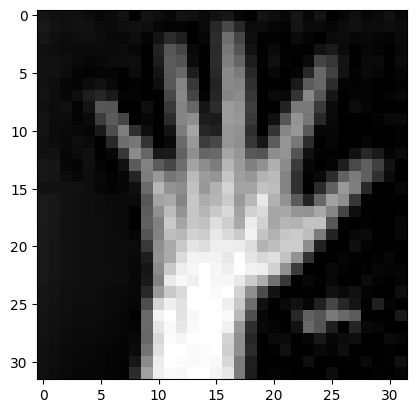

In [ ]:
image, label = train_dataset[10]
plt.imshow(image.squeeze(), cmap='gray')

## Network design and implementation

Network $G$:
- Consists of ConvTranspose2d (z_dim is length of latent vector) and BatchNorm2d
- Apply leaky_relu activation functions for the first several subsystem, and tanh for the last layer.
- LeakyReLU helps to mitigate Vanishing gradient problem


Network $D$:
- Consists of Conv2d (z_dim is length of latent vector) and BatchNorm2d
- Apply ReLU activation functions for the first several subsystem
- Eventually use a linear layer to adjust the output size
- Apply leaky_relu(alpha=0.2) activation functions, and sigmoid to the last layer

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels=1, image_size=32):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 256 * (image_size // 8) * (image_size // 8))
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 256, (image_size // 8), (image_size // 8))
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, channels=1, image_size=32):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        # Adjust the input size of the linear layer based on the output size of the convolutional layers
        self.fc = nn.Linear(256 * (image_size // 8) * (image_size // 8), 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc(x))
        return x


# define G and D models
image_size = 32
z_dim = 800

G = Generator(image_size=image_size, z_dim=z_dim).to(device)
D = Discriminator(image_size=image_size).to(device)

In [ ]:
G

Generator(
  (fc): Linear(in_features=800, out_features=4096, bias=True)
  (deconv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)

In [ ]:
D

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

In [ ]:
# define loss functions and optimizer
criterion = nn.BCELoss()
lr = 0.00005

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

## Training and evaluation loops

In [ ]:
def D_train(x):
    D.train()
    D_optimizer.zero_grad()

    # train discriminator on real data -- assign high score (use 1 here)
    x_real, y_real = x, torch.ones(x.size(0), 1).to(device)  # no need to flatten
    x_real, y_real = x_real.to(device), y_real.to(device)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake data -- assign low score (use 0 here)
    # sample vector and produce generator output
    z = torch.randn(x.size(0), z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(x.size(0), 1).to(device)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)

    # combine the losses
    D_loss = D_real_loss + D_fake_loss

    # model update
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [ ]:
def G_train(x):
    G.train()
    G_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    G_output = G(z)

    # obtain scores from D for the generated data
    D_output = D(G_output)

    # train generator to "fool" discriminator
    y = torch.ones(bs, 1).to(device)
    G_loss = criterion(D_output, y)

    # model update
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

## Network training
Use the best hyperparameters and network design here (and justify briefly your choices, linking them to the `yourusername_DLcw1_hypertune.ipynb` notebook.

Show loss evolution with livelossplot or any other graphic visualisation tool of your choice

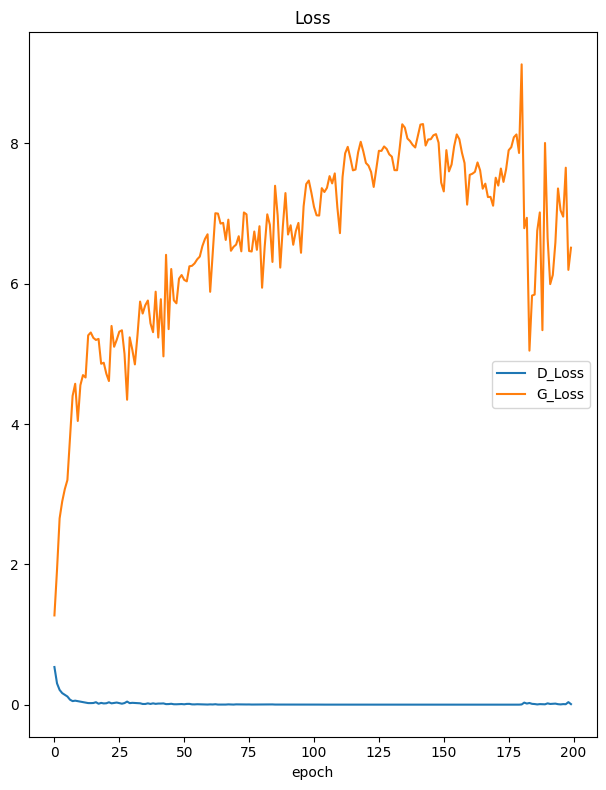

Loss
	D_Loss           	 (min:    0.000, max:    0.538, cur:    0.009)
	G_Loss           	 (min:    1.273, max:    9.126, cur:    6.513)


In [ ]:
n_epoch = 200
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x, _) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 20) == 0):
    torch.save(G.state_dict(), "./Generator_final_{:03d}.pth".format(epoch))

Text(0.5, 1.0, 'Epoch = 200')

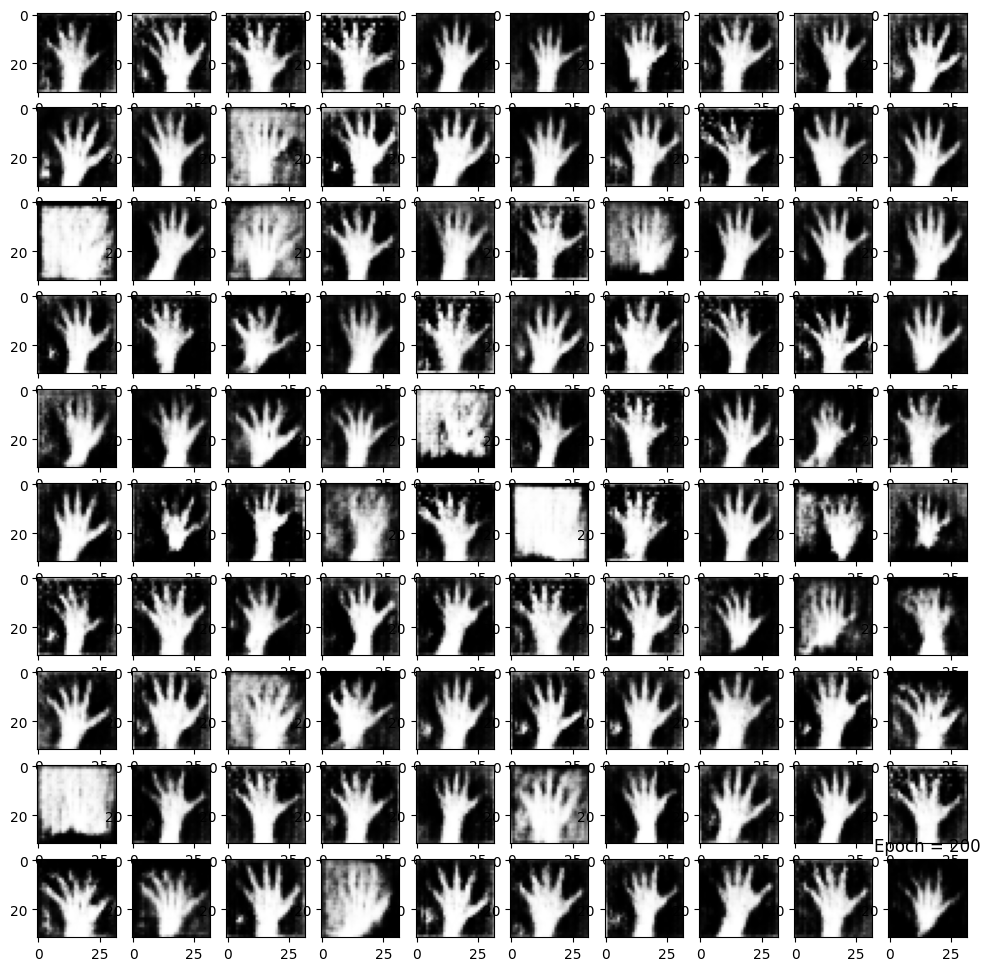

In [ ]:
set_seed(0)

epoch = 200  ## get the model after 200 epochs and use it:
G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))

with torch.no_grad():
    test_z = torch.randn(bs, z_dim).to(device)
    generated = G(test_z)

fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 32, 32).cpu()):
  ax.imshow(img, cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))

## Generate 300 new samples with your trained network

In [ ]:
def generate_samples(generator, path, num_samples=300):
    generator.eval()
    with torch.no_grad():
        for i in range(num_samples):
            z = torch.randn(1, generator.fc.in_features).to(device)  # fully connected to layer
            generated_img = generator(z)
            save_image(generated_img, f'{path}/hs1623_GAN{i + 1}.jpeg')
            print(f'Saved image {i + 1}/{num_samples}')

## Save the 300 generated samples as `.jpeg` files
The format of the saved samples should be `.jpeg`, and the names of the files should be:
- `yourusername_VAE001.jpeg`, `yourusername_VAE002.jpeg`, ... , `yourusername_VAE300.jpeg`

or

- - `yourusername_GAN001.jpeg`, `yourusername_GAN002.jpeg`, ... , `yourusername_GAN300.jpeg`

You can save your samples in your Google Drive or your local machine and then copy them to the repo where you will submit the answer.

add text blocks as you need

In [ ]:
generate_samples(G, path='/content/gdrive/My Drive/GAN_hands', num_samples=300)

Saved image 1/300
Saved image 2/300
Saved image 3/300
Saved image 4/300
Saved image 5/300
Saved image 6/300
Saved image 7/300
Saved image 8/300
Saved image 9/300
Saved image 10/300
Saved image 11/300
Saved image 12/300
Saved image 13/300
Saved image 14/300
Saved image 15/300
Saved image 16/300
Saved image 17/300
Saved image 18/300
Saved image 19/300
Saved image 20/300
Saved image 21/300
Saved image 22/300
Saved image 23/300
Saved image 24/300
Saved image 25/300
Saved image 26/300
Saved image 27/300
Saved image 28/300
Saved image 29/300
Saved image 30/300
Saved image 31/300
Saved image 32/300
Saved image 33/300
Saved image 34/300
Saved image 35/300
Saved image 36/300
Saved image 37/300
Saved image 38/300
Saved image 39/300
Saved image 40/300
Saved image 41/300
Saved image 42/300
Saved image 43/300
Saved image 44/300
Saved image 45/300
Saved image 46/300
Saved image 47/300
Saved image 48/300
Saved image 49/300
Saved image 50/300
Saved image 51/300
Saved image 52/300
Saved image 53/300
Sa